In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [3]:
IMG_SIZE = 512
PATCH_SIZE = 128
BATCH_SIZE = 2
EPOCHS = 500
T = 100  # diffusion steps
BETA_START = 1e-4
BETA_END = 6e-3
LEARNING_RATE = 1e-4


In [4]:
# -------------------- Utility Functions --------------------
def load_image(path, img_size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    arr = img.astype(np.float32) / 127.5 - 1.0
    return arr[..., None]


image = load_image('OCT.png')
betas = tf.constant(np.linspace(BETA_START, BETA_END, T), dtype=tf.float32)
alphas = 1.0 - betas
alpha_bars = tf.math.cumprod(alphas, axis=0)


def save_image(path, img_array):
    out = ((img_array + 1.0) * 127.5).astype(np.uint8)
    if out.ndim == 3 and out.shape[2] == 1:
        out = out[..., 0]
    cv2.imwrite(path, out)
    
# Forward diffusion q(x_t | x_0)
def q_sample(x0, t):
    x0 = tf.convert_to_tensor(x0, dtype=tf.float32)
    # ensure batch dimension
    if x0.ndim == 3:
        x0 = x0[None, ...]
    t = tf.convert_to_tensor(t, dtype=tf.int32)
    # gather alpha_bar for each t
    ab = tf.gather(alpha_bars, t)
    sqrt_ab = tf.sqrt(ab)
    sqrt_om = tf.sqrt(1.0 - ab)
    # reshape for broadcast to image dims
    sqrt_ab = tf.reshape(sqrt_ab, [-1,1,1,1])
    sqrt_om = tf.reshape(sqrt_om, [-1,1,1,1])
    noise = tf.random.normal(tf.shape(x0))
    x_t = sqrt_ab * x0 + sqrt_om * noise
    return x_t, noise

# -------------------- Dataset --------------------
def make_t_pair_dataset(x0_list, T):
    """
    x0_list: list of [H,W,1] float32 tensors in [-1,1]
    T      : total diffusion steps

    Returns a tf.data.Dataset that infinitely yields:
      inputs:  ((x_batch, t_batch), )
      target:   noise_batch

    where for each x0 in x0_list and each t in 1..T-1:
      x_batch     shape=[2,H,W,1]   = [x_t; x_{t-1}]
      t_batch     shape=[2]         = [t, t-1]
      noise_batch shape=[2,H,W,1]   = [ε_t; ε_{t-1}]
    """
    def gen():
        # finite loop over all x0 and t
        for x0 in x0_list:
            for t in range(1, T):
                # forward-sample at t and t-1 for this x0
                x_t,   eps_t   = q_sample(x0, [t])
                x_t_1, eps_t_1 = q_sample(x0, [t-1])
                # batch of 2
                x_batch     = tf.concat([x_t,   x_t_1],   axis=0)
                t_batch     = tf.convert_to_tensor([t, t-1], dtype=tf.int32)
                noise_batch = tf.concat([eps_t, eps_t_1], axis=0)
                yield (x_batch, t_batch), noise_batch

    # create a finite dataset, then repeat infinitely here
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (
                tf.TensorSpec([2, None, None, 1], tf.float32),
                tf.TensorSpec([2],            tf.int32)
            ),
            tf.TensorSpec([2, None, None, 1], tf.float32)
        )
    )
    return ds.repeat()  # <-- infinite repetition happens once, here




In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math


def get_timestep_embedding(timesteps, embedding_dim):
    """
    Sinusoidal timestep embeddings, identical to DDPM (Ho et al., 2020).
    Args:
        timesteps: tf.Tensor of shape [batch] (dtype=tf.int32 or tf.float32)
        embedding_dim: int, the dimensionality of the output embedding
    Returns:
        emb: tf.Tensor of shape [batch, embedding_dim], dtype=tf.float32
    """
    # 1) cast to float32 for the math
    timesteps = tf.cast(timesteps, tf.float32)
    
    # 2) half the channels go to sin(), half to cos()
    half_dim = embedding_dim // 2
    
    # 3) get a log-scale from 1 → 10000 over half_dim
    #    note the "-1" so that the maximum frequency is 10000^(−(half_dim−1)/(half_dim−1)) = 1/10000
    log_scale = math.log(10000.0) / (half_dim - 1)
    
    # 4) compute the inverse frequencies
    freqs = tf.exp(tf.range(half_dim, dtype=tf.float32) * -log_scale)  # [half_dim]
    
    # 5) outer‑product: [batch, 1] × [1, half_dim] → [batch, half_dim]
    args = timesteps[:, None] * freqs[None, :]
    
    # 6) stack sin and cos
    emb = tf.concat([tf.sin(args), tf.cos(args)], axis=1)  # [batch, 2*half_dim]
    
    # 7) if odd embedding_dim, pad one zero column
    if embedding_dim % 2 == 1:
        emb = tf.pad(emb, [[0, 0], [0, 1]])
    
    return emb


def swish_activation(x):
    """Swish activation function (same as nonlinearity in original)"""
    return x * tf.nn.sigmoid(x)


class GroupNormalization(layers.Layer):
    """Group Normalization layer"""
    def __init__(self, num_groups=32, epsilon=1e-6, **kwargs):
        super().__init__(**kwargs)
        self.num_groups = num_groups
        self.epsilon = epsilon
        
    def build(self, input_shape):
        channels = input_shape[-1]
        self.gamma = self.add_weight(
            shape=(channels,),
            initializer='ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(channels,),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        channels = x.shape[-1]
        
        # Reshape for group norm
        x = tf.reshape(x, [batch_size, height, width, self.num_groups, channels // self.num_groups])
        
        # Calculate mean and variance along group dimensions
        mean, variance = tf.nn.moments(x, axes=[1, 2, 4], keepdims=True)
        
        # Normalize
        x = (x - mean) / tf.sqrt(variance + self.epsilon)
        
        # Reshape back
        x = tf.reshape(x, [batch_size, height, width, channels])
        
        # Scale and shift
        return x * self.gamma + self.beta
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_groups': self.num_groups,
            'epsilon': self.epsilon
        })
        return config


class Upsample(layers.Layer):
    """Upsample layer with optional convolution"""
    def __init__(self, in_channels, with_conv=True, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = layers.Conv2D(
                in_channels, 
                kernel_size=3, 
                strides=1, 
                padding='same',
                name='conv'
            )
    
    def call(self, x):
        x = tf.image.resize(x, [tf.shape(x)[1] * 2, tf.shape(x)[2] * 2], method='nearest')
        if self.with_conv:
            x = self.conv(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'in_channels': self.in_channels,
            'with_conv': self.with_conv
        })
        return config


class Downsample(layers.Layer):
    """Downsample layer with optional convolution"""
    def __init__(self, in_channels, with_conv=True, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = layers.Conv2D(
                in_channels,
                kernel_size=3,
                strides=2,
                padding='valid',  # We'll handle padding manually
                name='conv'
            )
    
    def call(self, x):
        if self.with_conv:
            # Manual padding to match PyTorch's asymmetric padding
            x = tf.pad(x, [[0, 0], [0, 1], [0, 1], [0, 0]], mode='constant')
            x = self.conv(x)
        else:
            x = layers.AveragePooling2D(pool_size=2, strides=2)(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'in_channels': self.in_channels,
            'with_conv': self.with_conv
        })
        return config


class ResnetBlock(layers.Layer):
    """Residual block with timestep embedding"""
    def __init__(self, in_channels, out_channels=None, conv_shortcut=False, 
                 dropout=0.0, temb_channels=512, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels if out_channels is not None else in_channels
        self.conv_shortcut = conv_shortcut
        self.dropout_rate = dropout
        self.temb_channels = temb_channels
        
        self.norm1 = GroupNormalization(name='norm1')
        self.conv1 = layers.Conv2D(
            self.out_channels, 
            kernel_size=3, 
            strides=1, 
            padding='same',
            name='conv1'
        )
        
        self.temb_proj = layers.Dense(self.out_channels, name='temb_proj')
        
        self.norm2 = GroupNormalization(name='norm2')
        self.dropout = layers.Dropout(dropout, name='dropout')
        self.conv2 = layers.Conv2D(
            self.out_channels, 
            kernel_size=3, 
            strides=1, 
            padding='same',
            name='conv2'
        )
        
        if self.in_channels != self.out_channels:
            if self.conv_shortcut:
                self.shortcut_conv = layers.Conv2D(
                    self.out_channels, 
                    kernel_size=3, 
                    strides=1, 
                    padding='same',
                    name='conv_shortcut'
                )
            else:
                self.shortcut_conv = layers.Conv2D(
                    self.out_channels, 
                    kernel_size=1, 
                    strides=1, 
                    padding='same',
                    name='nin_shortcut'
                )
        else:
            self.shortcut_conv = None
    
    def call(self, x, temb, training=None):
        h = x
        h = self.norm1(h)
        h = swish_activation(h)
        h = self.conv1(h)
        
        # Add timestep embedding
        temb_proj = self.temb_proj(swish_activation(temb))
        temb_proj = temb_proj[:, None, None, :]  # Add spatial dimensions
        h = h + temb_proj
        
        h = self.norm2(h)
        h = swish_activation(h)
        h = self.dropout(h, training=training)
        h = self.conv2(h)
        
        # Shortcut connection
        if self.shortcut_conv is not None:
            x = self.shortcut_conv(x)
        
        return x + h
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'in_channels': self.in_channels,
            'out_channels': self.out_channels,
            'conv_shortcut': self.conv_shortcut,
            'dropout': self.dropout_rate,
            'temb_channels': self.temb_channels
        })
        return config


class AttnBlock(layers.Layer):
    """Self-attention block"""
    def __init__(self, in_channels, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        
        self.norm = GroupNormalization(name='norm')
        self.q = layers.Conv2D(in_channels, kernel_size=1, strides=1, padding='same', name='q')
        self.k = layers.Conv2D(in_channels, kernel_size=1, strides=1, padding='same', name='k')
        self.v = layers.Conv2D(in_channels, kernel_size=1, strides=1, padding='same', name='v')
        self.proj_out = layers.Conv2D(in_channels, kernel_size=1, strides=1, padding='same', name='proj_out')
    
    def call(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)
        
        # Compute attention
        batch_size = tf.shape(q)[0]
        height = tf.shape(q)[1]
        width = tf.shape(q)[2]
        channels = q.shape[-1]
        
        # Reshape for attention computation
        q = tf.reshape(q, [batch_size, height * width, channels])
        k = tf.reshape(k, [batch_size, channels, height * width])
        v = tf.reshape(v, [batch_size, channels, height * width])
        
        # Attention weights
        w_ = tf.matmul(q, k)  # [batch_size, hw, hw]
        w_ = w_ * (float(channels) ** (-0.5))
        w_ = tf.nn.softmax(w_, axis=-1)
        
        # Apply attention to values
        w_ = tf.transpose(w_, [0, 2, 1])  # [batch_size, hw, hw]
        h_ = tf.matmul(v, w_)  # [batch_size, channels, hw]
        h_ = tf.reshape(h_, [batch_size, height, width, channels])
        
        h_ = self.proj_out(h_)
        
        return x + h_
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'in_channels': self.in_channels
        })
        return config


class DiffusionUNet(keras.Model):
    """
    U-Net model for diffusion with timestep conditioning.
    """
    def __init__(self, ch=32, out_ch=1, ch_mult=(1, 2, 2, 2), num_res_blocks=2, 
                 attn_resolutions=[16], dropout=0.1, in_channels=1, resolution=512, 
                 resamp_with_conv=True, **kwargs):
        super().__init__(**kwargs)
        
        # Store configuration for serialization
        self.ch = ch
        self.out_ch = out_ch
        self.ch_mult = ch_mult
        self.num_res_blocks = num_res_blocks
        self.attn_resolutions = attn_resolutions
        self.dropout = dropout
        self.in_channels = in_channels
        self.resolution = resolution
        self.resamp_with_conv = resamp_with_conv
        
        self.temb_ch = self.ch * 4
        self.num_resolutions = len(self.ch_mult)
        
        # Build the model architecture
        self._build_model()
    
    def _build_model(self):
        """Build all the layers of the model"""
        # Timestep embedding
        self.temb_dense1 = layers.Dense(self.temb_ch, name='temb_dense1')
        self.temb_dense2 = layers.Dense(self.temb_ch, name='temb_dense2')
        
        # Initial convolution
        self.conv_in = layers.Conv2D(
            self.ch, 
            kernel_size=3, 
            strides=1, 
            padding='same',
            name='conv_in'
        )
        
        # Build downsampling path
        self._build_downsampling_blocks()
        
        # Build middle blocks
        self._build_middle_blocks()
        
        # Build upsampling path
        self._build_upsampling_blocks()
        
        # Final layers
        self.norm_out = GroupNormalization(name='norm_out')
        self.conv_out = layers.Conv2D(
            self.out_ch, 
            kernel_size=3, 
            strides=1, 
            padding='same',
            name='conv_out'
        )
    
    def _build_downsampling_blocks(self):
        """Build downsampling blocks"""
        self.down_blocks = []
        self.down_attns = []
        self.down_samples = []
        
        curr_res = self.resolution
        in_ch_mult = (1,) + self.ch_mult
        
        for i_level in range(self.num_resolutions):
            # Residual blocks for this level
            level_blocks = []
            level_attns = []
            
            block_in = self.ch * in_ch_mult[i_level]
            block_out = self.ch * self.ch_mult[i_level]
            
            for i_block in range(self.num_res_blocks):
                level_blocks.append(ResnetBlock(
                    in_channels=block_in,
                    out_channels=block_out,
                    temb_channels=self.temb_ch,
                    dropout=self.dropout,
                    name=f'down_{i_level}_block_{i_block}'
                ))
                block_in = block_out
                
                if curr_res in self.attn_resolutions:
                    level_attns.append(AttnBlock(block_in, name=f'down_{i_level}_attn_{i_block}'))
            
            self.down_blocks.append(level_blocks)
            self.down_attns.append(level_attns)
            
            # Downsampling
            if i_level != self.num_resolutions - 1:
                self.down_samples.append(Downsample(
                    block_in, 
                    self.resamp_with_conv,
                    name=f'down_{i_level}_sample'
                ))
                curr_res = curr_res // 2
            else:
                self.down_samples.append(None)
    
    def _build_middle_blocks(self):
        """Build middle blocks"""
        block_in = self.ch * self.ch_mult[-1]
        
        self.mid_block1 = ResnetBlock(
            in_channels=block_in,
            out_channels=block_in,
            temb_channels=self.temb_ch,
            dropout=self.dropout,
            name='mid_block1'
        )
        self.mid_attn = AttnBlock(block_in, name='mid_attn')
        self.mid_block2 = ResnetBlock(
            in_channels=block_in,
            out_channels=block_in,
            temb_channels=self.temb_ch,
            dropout=self.dropout,
            name='mid_block2'
        )
    
    def _build_upsampling_blocks(self):
        """Build upsampling blocks"""
        # Pre-allocate lists to avoid insert operations
        up_blocks_temp = [None] * self.num_resolutions
        up_attns_temp = [None] * self.num_resolutions
        up_samples_temp = [None] * self.num_resolutions
        
        curr_res = self.resolution // (2 ** (self.num_resolutions - 1))
        in_ch_mult = (1,) + self.ch_mult
        block_in = self.ch * self.ch_mult[-1]
        
        for i_level in reversed(range(self.num_resolutions)):
            level_blocks = []
            level_attns = []
            
            block_out = self.ch * self.ch_mult[i_level]
            skip_in = self.ch * self.ch_mult[i_level]
            
            for i_block in range(self.num_res_blocks + 1):
                if i_block == self.num_res_blocks:
                    skip_in = self.ch * in_ch_mult[i_level]
                
                level_blocks.append(ResnetBlock(
                    in_channels=block_in + skip_in,
                    out_channels=block_out,
                    temb_channels=self.temb_ch,
                    dropout=self.dropout,
                    name=f'up_{i_level}_block_{i_block}'
                ))
                block_in = block_out
                
                if curr_res in self.attn_resolutions:
                    level_attns.append(AttnBlock(block_in, name=f'up_{i_level}_attn_{i_block}'))
            
            # Use direct assignment instead of insert
            up_blocks_temp[i_level] = level_blocks
            up_attns_temp[i_level] = level_attns
            
            # Upsampling
            if i_level != 0:
                up_samples_temp[i_level] = Upsample(
                    block_in, 
                    self.resamp_with_conv,
                    name=f'up_{i_level}_sample'
                )
                curr_res = curr_res * 2
            else:
                up_samples_temp[i_level] = None
                
        # Assign the completed lists
        self.up_blocks = up_blocks_temp
        self.up_attns = up_attns_temp
        self.up_samples = up_samples_temp
    
    def call(self, inputs, training=None):
        # unpack the tuple
        x, t = inputs
        # Verify input dimensions
        tf.debugging.assert_equal(tf.shape(x)[1], self.resolution)
        tf.debugging.assert_equal(tf.shape(x)[2], self.resolution)
        
        # Timestep embedding
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb_dense1(temb)
        temb = swish_activation(temb)
        temb = self.temb_dense2(temb)
        
        # Initial convolution
        hs = [self.conv_in(x)]
        
        # Downsampling
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down_blocks[i_level][i_block](hs[-1], temb, training=training)
                if len(self.down_attns[i_level]) > i_block:
                    h = self.down_attns[i_level][i_block](h)
                hs.append(h)
            
            if self.down_samples[i_level] is not None:
                hs.append(self.down_samples[i_level](hs[-1]))
        
        # Middle
        h = hs[-1]
        h = self.mid_block1(h, temb, training=training)
        h = self.mid_attn(h)
        h = self.mid_block2(h, temb, training=training)
        
        # Upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks + 1):
                h = self.up_blocks[i_level][i_block](
                    tf.concat([h, hs.pop()], axis=-1), temb, training=training
                )
                if len(self.up_attns[i_level]) > i_block:
                    h = self.up_attns[i_level][i_block](h)
            
            if self.up_samples[i_level] is not None:
                h = self.up_samples[i_level](h)
        
        # Final output
        h = self.norm_out(h)
        h = swish_activation(h)
        h = self.conv_out(h)
        
        return h
    
    def get_config(self):
        """Return configuration for serialization"""
        config = super().get_config()
        config.update({
            'ch': self.ch,
            'out_ch': self.out_ch,
            'ch_mult': self.ch_mult,
            'num_res_blocks': self.num_res_blocks,
            'attn_resolutions': self.attn_resolutions,
            'dropout': self.dropout,
            'in_channels': self.in_channels,
            'resolution': self.resolution,
            'resamp_with_conv': self.resamp_with_conv
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        """Create model from configuration"""
        return cls(**config)

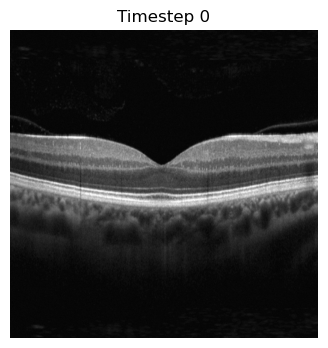

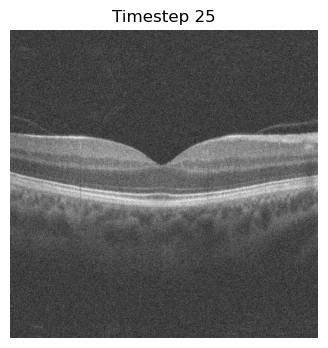

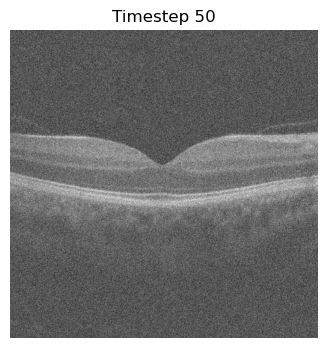

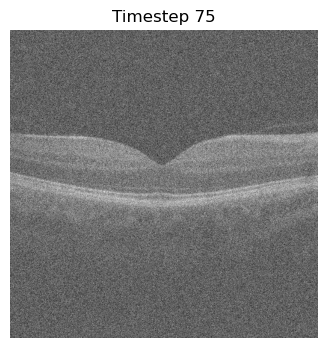

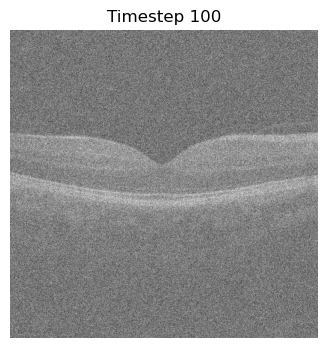

In [45]:
# show image at each T
image_np = load_image('OCT.png')  # base image as numpy array
for i in range(0, T+1, 25):
    # Perform forward diffusion for timestep i
    x_t, _ = q_sample(image_np, [i])  # returns tensor shape [1,H,W,1]
    img = x_t.numpy()[0, ..., 0]      # extract 2D image
    plt.figure(figsize=(4,4))
    plt.imshow((img + 1.0) / 2.0, cmap='gray')
    plt.title(f"Timestep {i}")
    plt.axis('off')
    plt.show()


In [8]:
import os
import tensorflow as tf

# Configuration
IMAGE_SHAPE = (512, 512, 1)
MODEL_CONFIG = {
    'ch': 32,
    'out_ch': 1,
    'ch_mult': (1, 2, 2, 2),
    'num_res_blocks': 2,
    'attn_resolutions': [16],
    'dropout': 0.1,
    'resolution': 512
}
OPTIMIZER_CONFIG = {'learning_rate': 5e-4}
TRAINING_CONFIG = {
    'epochs': 500,
    'checkpoint_dir': 'checkpoints',
    'model_save_path': 'diffusion_model.keras'
}

def create_model():
    """Create and compile the diffusion model."""
    # Define inputs
    image_input = tf.keras.Input(shape=IMAGE_SHAPE, name="image")
    timestep_input = tf.keras.Input(shape=(), name="timestep", dtype=tf.int32)
    
    # Create U-Net and get output
    unet = DiffusionUNet(**MODEL_CONFIG)
    output = unet((image_input, timestep_input))
    
    # Build and compile model
    model = tf.keras.Model([image_input, timestep_input], output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(**OPTIMIZER_CONFIG),
        loss='mse',
        metrics=['mse']
    )
    
    return model

def create_callbacks(checkpoint_dir='checkpoints'):
    """Create training callbacks."""
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, 'best_weights'),
            save_best_only=True,
            save_weights_only=True,
            monitor='loss',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    return callbacks

def prepare_dataset(image_paths, T):
    """Prepare the training dataset."""
    x0_list = [load_image(img) for img in image_paths]
    train_ds = make_t_pair_dataset(x0_list, T).repeat()
    return train_ds

def load_saved_model(filepath):
    """Load a saved model with custom objects."""
    custom_objects = {
        'DiffusionUNet': DiffusionUNet,
        'GroupNormalization': GroupNormalization,
        'get_timestep_embedding': get_timestep_embedding,
        'swish_activation': swish_activation,
        'ResnetBlock': ResnetBlock,
        'AttnBlock': AttnBlock,
        'Downsample': Downsample,
        'Upsample': Upsample
    }
    return tf.keras.models.load_model(filepath, custom_objects=custom_objects)

# Main training script
if __name__ == "__main__":
    # Dataset preparation
    images = ['OCT.png']
    
    print("Creating model...")
    model = create_model()
    model.summary()
    
    print("Preparing dataset...")
    train_ds = prepare_dataset(images, T)
    
    print("Creating callbacks...")
    callbacks = create_callbacks(TRAINING_CONFIG['checkpoint_dir'])
    
    print("Starting training...")
    history = model.fit(
        train_ds,
        epochs=TRAINING_CONFIG['epochs'],
        steps_per_epoch=(T-1) * len(images),
        callbacks=callbacks,
        verbose=1
    )
    
    print("Saving model...")
    model.save(TRAINING_CONFIG['model_save_path'])
    print(f"Model saved to {TRAINING_CONFIG['model_save_path']}")
    
    # To load the model later:
    # model = load_saved_model('diffusion_model.keras')

Creating model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 timestep (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 diffusion_u_net (DiffusionUNet  (None, 512, 512, 1)  2160769    ['image[0][0]',                  
 )                                                                'timestep[0][0]']               
                                                                            

KeyboardInterrupt: 

In [47]:
model.save('diffusion_model')

INFO:tensorflow:Assets written to: diffusion_model\assets


INFO:tensorflow:Assets written to: diffusion_model\assets


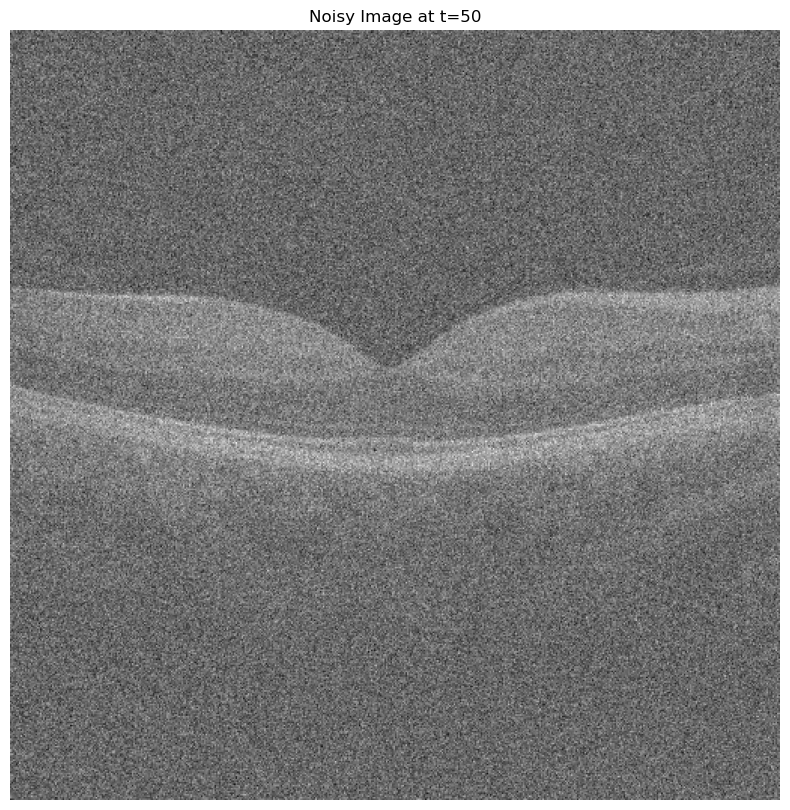

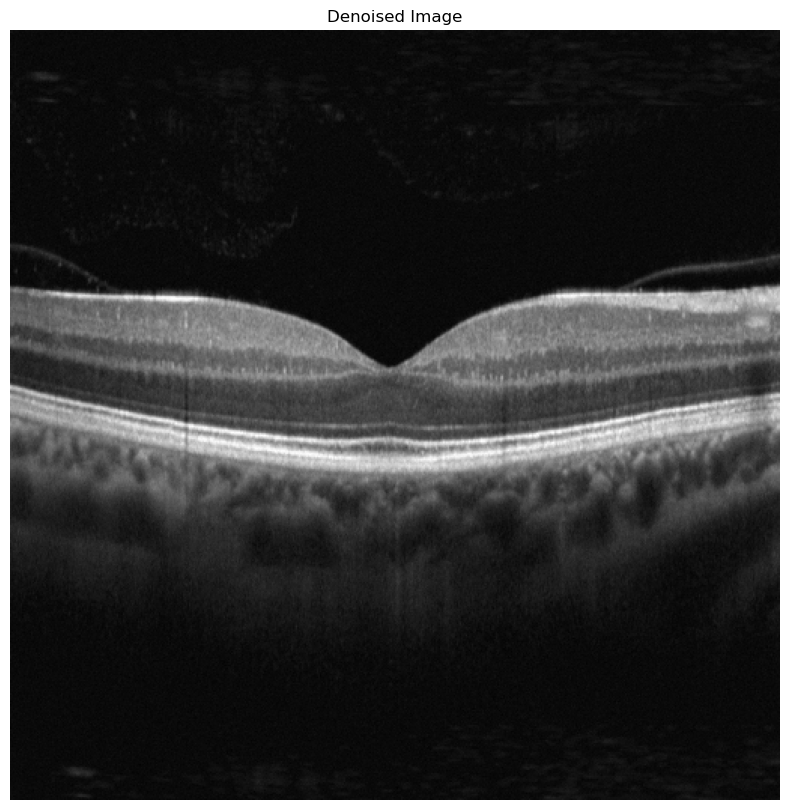

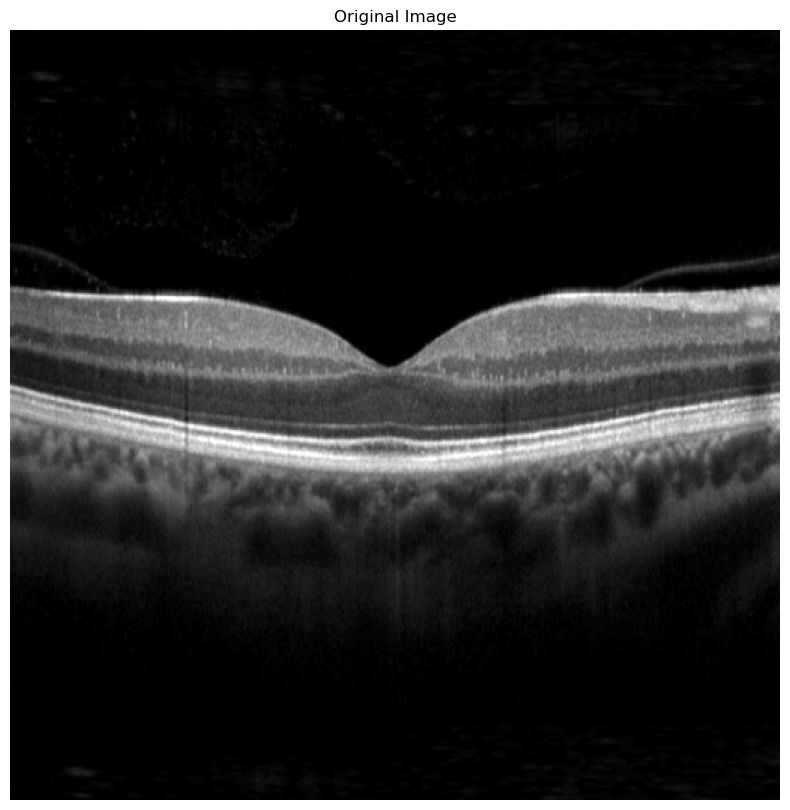

In [14]:
@tf.function
def denoise(x0, t_start=50, model=model2):
    x = x0
    for time_step in tf.range(t_start, 0, -1):
        t_tensor = tf.fill([tf.shape(x)[0]], time_step)
        eps = model((x, t_tensor))
        beta = tf.gather(betas, time_step)
        alpha = tf.gather(alphas, time_step)
        alpha_bar = tf.gather(alpha_bars, time_step)
        coef1 = 1.0 / tf.sqrt(alpha)
        coef2 = beta / tf.sqrt(1.0 - alpha_bar)
        x = coef1 * (x - coef2 * eps)
        if time_step > 1:
            noise = tf.random.normal(tf.shape(x)) * tf.sqrt(beta)
            x += noise
    return x

# Run denoising
base = load_image('OCT.png')[None, ...]        # shape [1, H, W, 1]
noisy, _ = q_sample(base, [100])                # x_t at t=50
dirty = noisy            
                      # rename for clarity

# 2) show noisy
plt.figure(figsize=(10,10))
plt.imshow((dirty[0,...,0] + 1.0)/2.0, cmap='gray')
plt.title('Noisy Image at t=50')
plt.axis('off')
plt.show()

# 3) denoise
denoised = denoise(dirty, t_start=100)          # still shape [1,H,W,1]
denoised_np = denoised.numpy()[0,...,0]

# 4) show & save result
plt.figure(figsize=(10,10))
plt.imshow((denoised_np + 1.0)/2.0, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow((base[0,...,0] + 1.0)/2.0, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


# # after computing `dirty`, `denoised_np`, and `base`…

# figures = [
#     (dirty.numpy()[0, ..., 0], 'Noisy Image at t=50',   'noisy_figure.png'),
#     (denoised_np,                  'Denoised Image',       'denoised_figure.png'),
# ]

# for img_arr, title, filename in figures:
#     plt.figure(figsize=(4,4))
#     plt.imshow((img_arr + 1.0)/2.0, cmap='gray')
#     plt.title(title)
#     plt.axis('off')
#     # save exactly what the figure looks like
#     plt.savefig(
#         filename,
#         dpi=300,               # optional: higher-res output
#         bbox_inches='tight',   # trim margins
#         pad_inches=0           # no extra padding
#     )
#     plt.show()
#     print(f"Saved {filename}")





In [9]:
model2 = load_saved_model('diffusion_model')

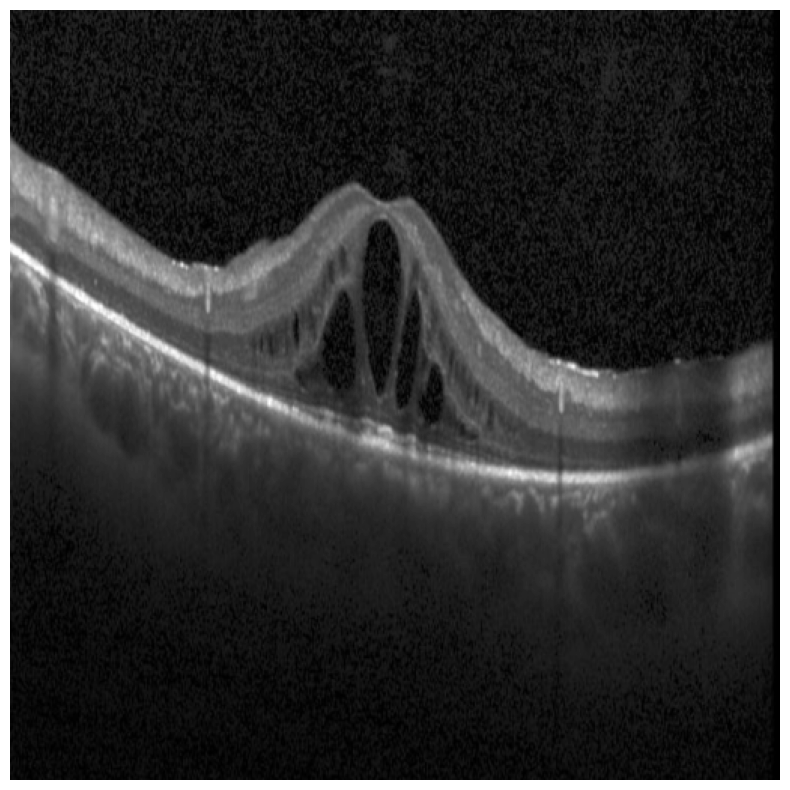

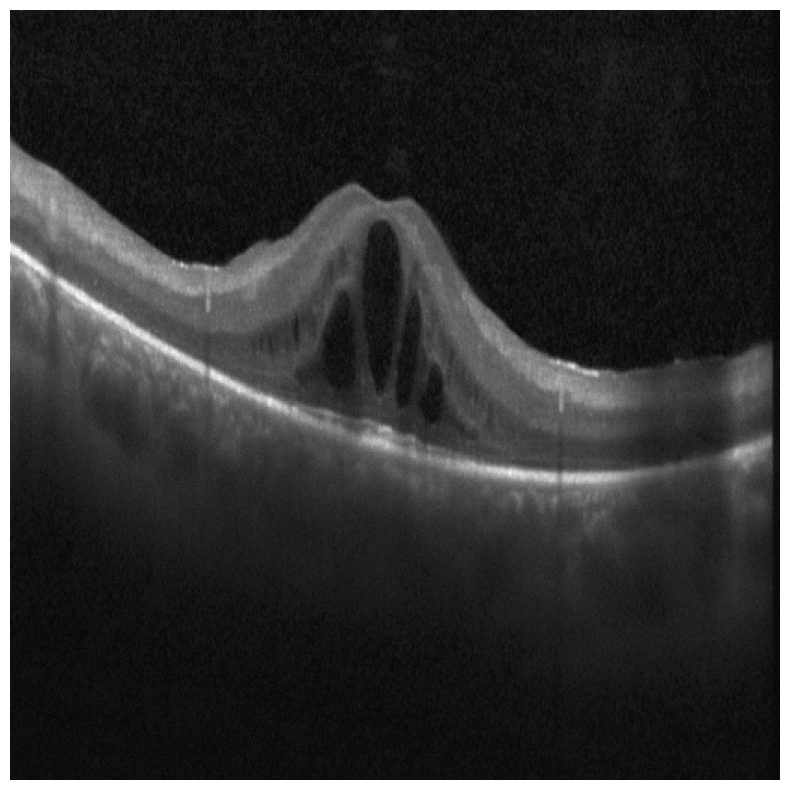

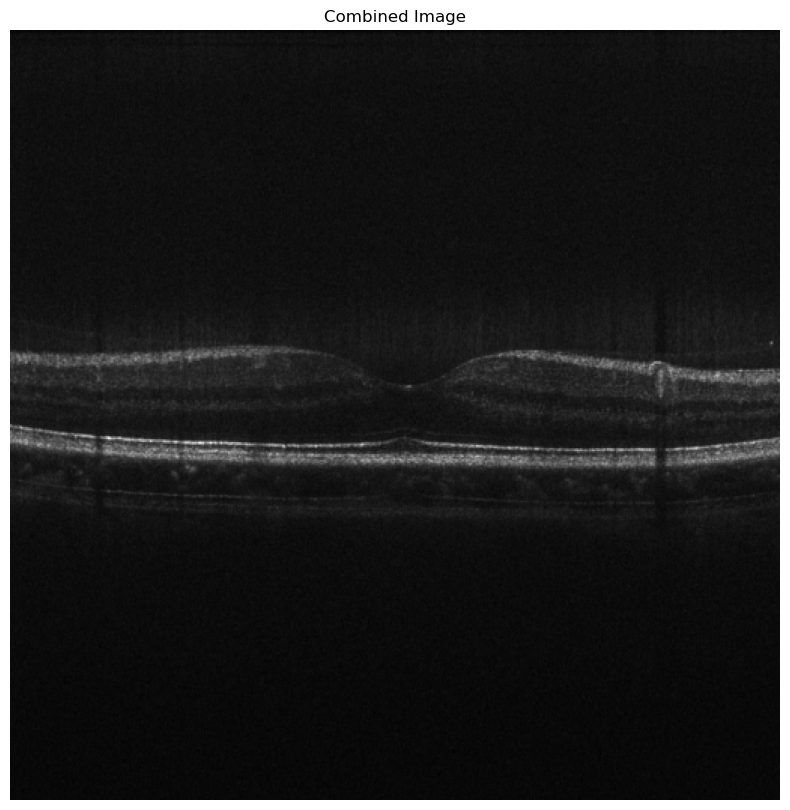

In [43]:
# testimg = load_image("OCT_10periods.png")
# testimg = load_image(r"really_bad.png")
# testimg = load_image(r"chong3.png")
# testimg = load_image(r"igor_maybe.png")

# testimg = load_image(r"C:\Projects\denoise\\vessel.png")
# testimg = load_image("Test.png")
# testimg = load_image("alexg_06.png")
testimg = load_image("gross.png")

# testimg = load_image(r"noisemap.png")  # test image for denoising
# run adaptive normalization kernel

# Show test image
plt.figure(figsize=(10,10))
# prepare image for denoise
plt.imshow((testimg + 1.0) / 2.0, cmap='gray')
plt.axis('off')
plt.show()

betas = tf.constant(np.linspace(BETA_START, BETA_END, T), dtype=tf.float32)
alphas = 1.0 - betas
alpha_bars = tf.math.cumprod(alphas, axis=0)
denoised = denoise(testimg[None, ...],4, model = model2)  # denoise test 
# sharpen 

denoised_np = denoised.numpy()[0, ..., 0]

kernel_subtle = np.array([
    [  0.0,   -0.1,   0.0],
    [ -0.1,   1,  -0.1],
    [  0.0,   -0.1,   0.0]
], dtype=np.float32)

# apply sharpening
sharpened_np = cv2.filter2D(denoised_np, ddepth=-1, kernel=kernel_subtle)

# 2) Clip to [-1, 1]
sharpened_np = np.clip(sharpened_np, -1.0, 1.0)

# 3) Map to [0, 1]
sh = (sharpened_np + 1.0) / 2.0

gamma = 1.2
sh_gamma = np.power(sh, gamma)

# 4) Map back to [-1, 1]
sh_gamma_mapped = sh_gamma * 2.0 - 1.0

plt.figure(figsize=(10,10))
plt.imshow(sh_gamma_mapped, cmap='gray')          # or sh_gamma_mapped if you mapped back
plt.axis('off')
plt.show()

# # combined image
combined = load_image("OCT_AVERAGE.png")

plt.figure(figsize=(10,10))
# prepare image for denoise
plt.imshow((combined + 1.0) / 2.0, cmap='gray')
plt.title('Combined Image')
plt.axis('off')
plt.show()



In [ ]:
# -------------------- Utility Functions --------------------
def load_image(path, img_size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    arr = img.astype(np.float32) / 127.5 - 1.0
    return arr[..., None]


image = load_image('OCT.png')
betas = tf.constant(np.linspace(BETA_START, BETA_END, T), dtype=tf.float32)
alphas = 1.0 - betas
alpha_bars = tf.math.cumprod(alphas, axis=0)


def save_image(path, img_array):
    out = ((img_array + 1.0) * 127.5).astype(np.uint8)
    if out.ndim == 3 and out.shape[2] == 1:
        out = out[..., 0]
    cv2.imwrite(path, out)
    
# Forward diffusion q(x_t | x_0)
def q_sample(x0, t):
    x0 = tf.convert_to_tensor(x0, dtype=tf.float32)
    # ensure batch dimension
    if x0.ndim == 3:
        x0 = x0[None, ...]
    t = tf.convert_to_tensor(t, dtype=tf.int32)
    # gather alpha_bar for each t
    ab = tf.gather(alpha_bars, t)
    sqrt_ab = tf.sqrt(ab)
    sqrt_om = tf.sqrt(1.0 - ab)
    # reshape for broadcast to image dims
    sqrt_ab = tf.reshape(sqrt_ab, [-1,1,1,1])
    sqrt_om = tf.reshape(sqrt_om, [-1,1,1,1])
    noise = tf.random.normal(tf.shape(x0))
    x_t = sqrt_ab * x0 + sqrt_om * noise
    return x_t, noise

# -------------------- Dataset --------------------
def make_t_pair_dataset(x0_list, T):
    """
    x0_list: list of [H,W,1] float32 tensors in [-1,1]
    T      : total diffusion steps

    Returns a tf.data.Dataset that infinitely yields:
      inputs:  ((x_batch, t_batch), )
      target:   noise_batch

    where for each x0 in x0_list and each t in 1..T-1:
      x_batch     shape=[2,H,W,1]   = [x_t; x_{t-1}]
      t_batch     shape=[2]         = [t, t-1]
      noise_batch shape=[2,H,W,1]   = [ε_t; ε_{t-1}]
    """
    def gen():
        # finite loop over all x0 and t
        for x0 in x0_list:
            for t in range(1, T):
                # forward-sample at t and t-1 for this x0
                x_t,   eps_t   = q_sample(x0, [t])
                x_t_1, eps_t_1 = q_sample(x0, [t-1])
                # batch of 2
                x_batch     = tf.concat([x_t,   x_t_1],   axis=0)
                t_batch     = tf.convert_to_tensor([t, t-1], dtype=tf.int32)
                noise_batch = tf.concat([eps_t, eps_t_1], axis=0)
                yield (x_batch, t_batch), noise_batch

    # create a finite dataset, then repeat infinitely here
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (
                tf.TensorSpec([2, None, None, 1], tf.float32),
                tf.TensorSpec([2],            tf.int32)
            ),
            tf.TensorSpec([2, None, None, 1], tf.float32)
        )
    )
    return ds.repeat()  # <-- infinite repetition happens once, here




In [42]:
# calculate signal to noise
def calculate_snr(original, denoised):
    """
    Calculate Signal-to-Noise Ratio (SNR) between original and denoised images.
    """
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')  # No noise, infinite SNR
    snr = 20 * np.log10(np.max(original) / np.sqrt(mse))
    return snr

# Calculate SNR
snr_value = calculate_snr(testimg, sh_gamma_mapped)
print(f"SNR: {snr_value:.2f} dB")

SNR: 10.64 dB
